#### Ciencia de datos - Primavera 2024
##### Integrantes: Magdalena Cobb, Pedro García Vassallo, Marcos Olavarría
### Trabajo Práctico 4

## 1. Lectura de la base

In [3]:
#Paquetes y librerías a usar
#!pip install openpyxl
#!pip install statsmodels

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from matplotlib.ticker import FuncFormatter

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
#from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegressionCV

In [4]:
#Lectura del documento
indi_2024 = pd.read_excel('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/usu_individual_T124.xlsx') 
indi_2004 = pd.read_stata('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/Individual_t104.dta')
hoga_2024 = pd.read_excel('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/usu_hogar_T124.xlsx')
hoga_2004 = pd.read_stata('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/Hogar_t104.dta')

# Maggie: C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/
# Peter: 'C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 4/
# Marck: C:/Users/marcos.olavarria/Documents/GitHub/CC408/TP 4/


## 2. Selección de GBA y merge

(2)

In [5]:
#Filtramos las bases para tener solo Buenos Aires
ind_2024 = indi_2024[(indi_2024['AGLOMERADO'] == 33) | (indi_2024['AGLOMERADO'] == 32)]
hog_2024 = hoga_2024[(hoga_2024['AGLOMERADO'] == 33) | (hoga_2024 ['AGLOMERADO'] == 32 )]

ind_2004 = indi_2004[(indi_2004['aglomerado'] == 'Ciudad de Buenos Aires') | (indi_2004 ['aglomerado'] == 'Partidos del GBA' )]
hog_2004 = hoga_2004[(hoga_2004['aglomerado'] == 'Ciudad de Buenos Aires') | (hoga_2004 ['aglomerado'] == 'Partidos del GBA' )]

#Pasamos los nombres de las columnas a mayusculas
ind_2004.columns = ind_2004.columns.str.upper()
hog_2004.columns = hog_2004.columns.str.upper()


(3) Limpieza de variables

In [6]:
#Eliminación de columnas redundantes (preguntas hechas solo para ocupados o desocupados)
redundantes_ind04 = [
    "CAT_INAC",
    "PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3",
    "PP11A", "PP11B_COD", "PP11B1", "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA", "PP11C", "PP11C99", "PP11D_COD",
    "PP11G_ANO", "PP11G_MES", "PP11G_DIA", "PP11L", "PP11L1", "PP11M", "PP11N", "PP11O", "PP11P", "PP11Q", "PP11R", 
    "PP11S", "PP11T", "PP02C1", "PP02C2", "PP02C3", "PP02C4", "PP02C5", "PP02C6", "PP02C7", "PP02C8", "PP02E", 
    "PP02H", "PP02I", "CAT_OCUP", "PP03C", "PP03D", "PP3E_TOT", "PP3F_TOT", "PP03G", "PP03H", "PP03I", "PP03J", 
    "INTENSI", "PP04A", "PP04B_COD", "PP04B1", "PP04B2", "PP04B3_MES", "PP04B3_ANO", "PP04B3_DIA", "PP04C", 
    "PP04C99", "PP04D_COD", "PP04G", "PP05B2_MES", "PP05B2_ANO", "PP05B2_DIA", "PP05C_1", "PP05C_2", "PP05C_3", 
    "PP05E", "PP05F", "PP05H", "PP06A", "PP06C", "PP06E", "PP06H", "PP06D", "PP07A", "PP07C", "PP07D", "PP07E", "PP07F1", "PP07F2", 
    "PP07F3", "PP07F4", "PP07F5", "PP07G1", "PP07G2", "PP07G3", "PP07G4", "PP07G_59", "PP07H", "PP07I", "PP07J", 
    "PP07K", "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "TOT_P12", "PJ1_1", 
    "PJ2_1", "PJ3_1", "IDIMPP", 'PP09A', 'PP09A_ESP',  'PP09B', 'PP09C',  'PP09C_ESP',  'PP10A','PP10C',  'PP10D', 'PP10E', 
    'CH15_COD', 'CH16_COD', 'IDECINDR', 'PDECINDR', 'IDECCFR', 'PDECCFR']

redundantes_hog04 = [
    "II3",
    "II3_1",
    "II6",
    "II6_1", 
    'IDIMPH' , 'IV1_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP', 'IDECIFR', 'PDECIFR', 'IDECCFR', 'PDECCFR', 'MAS_500'
]

redundantes_ind24 = [
    "PP02C1", "PP02C2", "PP02C3", "PP02C4", "PP02C5", "PP02C6", "PP02C7", "PP02C8",
    "PP02E", "PP02H", "PP02I", "PP10A", "PP10C", "PP10D", "PP10E", "PP11A",
    "PP11B_COD", "PP11B1", "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA", "PP11C", 
    "PP11C99", "PP11D_COD", "PP11G_ANO", "PP11G_MES", "PP11G_DIA", "PP11L", "PP11L1",
    "PP11M", "PP11N", "PP11O", "PP11P", "PP11Q", "PP11R", "PP11S", "PP11T",
    "PP03C", "PP03D", "PP3E_TOT", "PP3F_TOT", "PP03G", "PP03H", "PP03I", "PP03J",
    "INTENSI", "PP04A", "PP04B_COD", "PP04B1", "PP04B2", "PP04B3_MES", "PP04B3_ANO",
    "PP04C", "PP04C99", "PP04D_COD", "PP04G", "PP05B2_MES", "PP05B2_ANO", "PP05B2_DIA", 'PP04B3_DIA',
    "PP05C_1", "PP05C_2", "PP05C_3", "PP05E", "PP05F", "PP05H", "PP06A", "PP06C",
    "PP06D", "PP06E", "PP06H", "PP07A", "PP07C", "PP07D", "PP07E", "PP07F1", "PP07F2",
    "PP07F3", "PP07F4", "PP07F5", "PP07G1", "PP07G2", "PP07G3", "PP07G4", "PP07G_59",
    "PP07H", "PP07I", "PP07J", "PP07K", "PP08D1", "PP08D4", "PP08F1", "PP08F2", 
    "PP08J1", "PP08J2", "PP08J3", "PP09A", "PP09A_ESP", "PP09B", "PP09C", "PP09C_ESP",
    "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR",
    "PONDIIO", "TOT_P12", "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", 
    "PDECINDR", "ADECINDR", "PONDII",  'PP10A',  'PP10C', 'PP10D',  'PP10E', 'CH15_COD', 'CH16_COD', 
    'IDECINDR', 'PDECINDR', 'IDECCFR', 'PDECCFR', 'CH05'
]

redundantes_hog24 = [
    "II3",
    "II3_1",
    "II6",
    "II6_1", 'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP','IDECIFR', 'PDECIFR', 'IDECCFR', 'PDECCFR', 'MAS_500'

]


In [7]:
#Eliminamos las variables redundantes de las bases
ind_2004 = ind_2004.drop(columns = redundantes_ind04)
ind_2024 = ind_2024.drop(columns = redundantes_ind24)
hog_2004 = hog_2004.drop(columns = redundantes_hog04)
hog_2024 = hog_2024.drop(columns = redundantes_hog24)

In [8]:
#Sacamos de las bases individuales variables que van a aparecer en hogar, para emprolijar el merge
lista_con = ['ANO4', 'TRIMESTRE', 'REGION',  'AGLOMERADO', 'PONDERA', 'ITF', 'DECIFR', 'IDECIFR', 
             'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR','ADECCFR']

lista_con2 = ['ANO4', 'TRIMESTRE', 'REGION', 'AGLOMERADO', 'PONDERA', 'ITF', 'DECIFR', 'IDECIFR', 'RDECIFR',
              'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR', 'ADECCFR','PONDIH']

ind_2004 = ind_2004.drop (columns = (lista_con))
ind_2024 = ind_2024.drop(columns = (lista_con2))

In [9]:
#Mergeamos bases hogar + individual para cada año
combined_04 = pd.merge(ind_2004, hog_2004, on=['CODUSU', 'NRO_HOGAR'], how='outer') #7647 obs x 124 variables
combined_24 = pd.merge(ind_2024,hog_2024,on=["CODUSU","NRO_HOGAR"], how = 'outer') #7051 obs x 120 variables


## 3. Limpieza

##### (3) Limpieza de observaciones con valores negativos

In [10]:
#Elimino filas con valores negativos para 2004
combined_04_clean = combined_04[~(combined_04.select_dtypes(include=[float, int]) < 0).any(axis=1)]
combined_04 = combined_04_clean

#Elimino filas con valores negativos para 2024
combined_24_clean = combined_24[~(combined_24.select_dtypes(include=[float, int]) < 0).any(axis=1)]
combined_24 = combined_24_clean


##### (3) Valores Faltantes

In [11]:
#Identificacion de columnas con NaN para 2004
nan_values04 = combined_04.select_dtypes(include=[float, int]).isna().any()
columnas_con_nan04 = nan_values04[nan_values04] 
columnas_con_nan04 = columnas_con_nan04.index

print("Columna con NaN para 2004:", columnas_con_nan04)

#Eliminacion de una columna con NaNs
combined_04 = combined_04.drop(columns = (columnas_con_nan04))

Columna con NaN para 2004: Index(['IX_MEN10'], dtype='object')


In [12]:
#Identificacion de columnas con NaN para 2024
nan_values24 = combined_24.isna().any()
columnas_con_nan24 = nan_values24[nan_values24] 

print("Columnas con NaN para 2024:\n", columnas_con_nan24)

columnas_con_nan24 = columnas_con_nan24.index


Columnas con NaN para 2024:
 CH14      True
IMPUTA    True
dtype: bool


In [13]:
# Funcion para identificar porcentaje de valores faltantes por columna
# (Esto no es tan necesario para solo dos columnas, 
# pero servia para identificar la base antes de filtrar las columnas en los incisos anteriores)

lista_nans_poco = []
lista_nans_50 = []
lista_nans_60 = []
lista_nans_70 = []
lista_nans_80 = []
lista_nans_90 = []
lista_nans_100 = []

for i in columnas_con_nan24:
    proporcion_columna24 = combined_24[i].isnull().sum() / len(combined_24) * 100
    
    if proporcion_columna24 < 50:
        lista_nans_poco.append(i)

    elif proporcion_columna24 >= 50 and proporcion_columna24 < 60:
        lista_nans_50.append(i)

    elif proporcion_columna24 >= 60 and proporcion_columna24 < 70:
        lista_nans_60.append(i)

    elif proporcion_columna24 >= 70 and proporcion_columna24 < 80:
        lista_nans_70.append(i)

    elif proporcion_columna24 >= 80 and proporcion_columna24 < 90:
        lista_nans_80.append(i)

    elif proporcion_columna24 >= 90 and proporcion_columna24 < 100:
        lista_nans_90.append(i)

    elif proporcion_columna24 == 100:
        lista_nans_100.append(i)
    

In [14]:
# Elimino las variables que tienen más de 90% de datos Nan
columnas_elim = lista_nans_90 + lista_nans_100
combined_24 = combined_24.drop(columns = (columnas_elim)) 

# Imputo por la mediana en las columnas que su proporción de Nans < 90
columnas_ok = lista_nans_poco + lista_nans_50 +lista_nans_60 + lista_nans_70 + lista_nans_80
combined_24[columnas_ok] = combined_24[columnas_ok].fillna(combined_24[columnas_ok].median())

##### (3) Outliers 

In [15]:
#Definimos lista de variables numericas para revisar outliers
numerica04 = [ 'P47T','IV2', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M',
                    'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI',
                       'PONDERA', 'II5_1', 'IX_TOT', 'IX_MAYEQ10', 'ITF']

numerica24 = ['CH06', 'ESTADO', 'V2_M', 
                  'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM',
                    'V21_M', 'T_VI', 'II1', 'II2', 'II5_1', 
                        'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'ITF', 'DECIFR', 'RDECIFR', 'GDECIFR', 'ADECIFR',
                          'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR', 'ADECCFR', 'PONDIH', 'IV2']

In [16]:
# Identificacion de outliers para 2004

combined_04[numerica04] = combined_04[numerica04].apply(pd.to_numeric, errors='coerce')

# Calculamos los cuartiles y el IQR solo para las columnas numéricas
Q1 = combined_04[numerica04].quantile(0.25)
Q3 = combined_04[numerica04].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Detectamos outliers
outliers = (combined_04[numerica04] < lower_limit) | (combined_04[numerica04] > upper_limit)

outliers_data = combined_04[outliers.any(axis=1)]

# Eliminamos filas con outliers
combined_04_no_outliers = combined_04[~outliers.any(axis=1)]

combined_04 = combined_04_no_outliers

In [17]:
#Identificamos y eliminamos outliers para 2024
combined_24[numerica24] = combined_24[numerica24].apply(pd.to_numeric, errors='coerce')

# Calculamos los cuartiles y el IQR solo para las columnas numéricas
Q1 = combined_24[numerica24].quantile(0.25)
Q3 = combined_24[numerica24].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Detectamos outliers 
outliers24 = (combined_24[numerica24] < lower_limit) | (combined_24[numerica24] > upper_limit)
outliers_data24 = combined_24[outliers24.any(axis=1)]
outliers_count24 = outliers24.sum()

# Eliminar filas con outliers
combined_24_no_outliers = combined_24[~outliers24.any(axis=1)]
combined_24 = combined_24_no_outliers

##### (3) Variables categoricas

In [18]:
#Todas las variables de las bases 2004 y 2024
lista04 = combined_04.columns.to_list()

lista24 = combined_24.columns.to_list()

In [19]:
#Lista de todas las variables que no quiero que sean dummies. Incluye numercias continuas y binarias (0,1).
nocategorica04 = ['CODUSU',
 'NRO_HOGAR',
 'COMPONENTE',
 'CH06',
 'ESTADO', #Estado es categorica, pero lo dejamos porque despues vamos a usar una dummy de desocupado directamente. 
 'P47T',
 'DECINDR',
 'RDECINDR',
 'GDECINDR',
 'ADECINDR',
 'V2_M',
 'V3_M',
 'V4_M',
 'V5_M',
 'V8_M',
 'V9_M',
 'V10_M',
 'V11_M',
 'V12_M',
 'V18_M',
 'V19_AM',
 'V21_M',
 'T_VI',
 'REALIZADA',
 'ANO4',
 'TRIMESTRE',
 'REGION',
 'AGLOMERADO',
 'PONDERA',
 'IV2',
 'II1',
 'II2',
 'II5_1',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'ITF',
 'DECIFR',
 'RDECIFR',
 'GDECIFR',
 'ADECIFR',
 'IPCF',
 'DECCFR',
 'RDECCFR',
 'GDECCFR',
 'ADECCFR']

nocategorica24 = ['CODUSU',
 'NRO_HOGAR',
 'COMPONENTE',
 'CH06',
 'ESTADO',
 'V2_M',
 'V3_M',
 'V4_M',
 'V5_M',
 'V8_M',
 'V9_M',
 'V10_M',
 'V11_M',
 'V12_M',
 'V18_M',
 'V19_AM',
 'V21_M',
 'T_VI',
 'ANO4',
 'TRIMESTRE',
 'REALIZADA',
 'REGION',
 'AGLOMERADO',
 'PONDERA',
 'II1',
 'II2',
 'II5_1',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'ITF',
 'DECIFR',
 'RDECIFR',
 'GDECIFR',
 'ADECIFR',
 'IPCF',
 'DECCFR',
 'RDECCFR',
 'GDECCFR',
 'ADECCFR',
 'PONDIH', 'IV2']

In [20]:
#Lista de todas las variables categoricas para 2004 y 2024
categorica04 = list(set(lista04) - set(nocategorica04))
categorica24 = list(set(lista24)- set(nocategorica24))

In [21]:
#Preparamos las variables categoricas para poder hacer dummies
#Elimina categorias sin usar para que el get dummies no sea redundante
for i in categorica04: 
    combined_04[i] = combined_04[i].astype('category')
    combined_04[i] = combined_04[i].cat.remove_unused_categories() 

for i in categorica24: 
    combined_24[i] = combined_24[i].astype('category')
    combined_24[i] = combined_24[i].cat.remove_unused_categories()

In [22]:
#Antes de convertir en dummies, definimos las bases con el total de los datos para poder hacer analisis discriptivos
combined_04_total = combined_04
combined_24_total = combined_24

In [23]:
#Generamos dummies de las variables categoricas para cada una de las bases
combined_04 = pd.get_dummies(combined_04, columns = categorica04, drop_first=True)
combined_24 = pd.get_dummies(combined_24, columns = categorica24, drop_first=True)

In [24]:
#Limpia algunos valores de la variable numerica CH06 (edad) para que sea de tipo int.
combined_04['CH06'] = combined_04['CH06'].replace('Menos de 1 año', 0)
combined_04['CH06'] = combined_04['CH06'].replace('98 y más años', 100)
combined_04['CH06'] = combined_04['CH06'].astype(int)

#Transforma las variables en numericas para poder usarlas en los modelos
col_transform = ['IV2', 'II1', 'II2']
for i in col_transform: 
    combined_04[i] = combined_04[i].astype(str)
    combined_04[i] = combined_04[i].astype(float)
    combined_04[i] = combined_04[i].astype(int)

C:\Users\magda\AppData\Local\Temp\ipykernel_27536\814526912.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  combined_04['CH06'] = combined_04['CH06'].replace('Menos de 1 año', 0)
C:\Users\magda\AppData\Local\Temp\ipykernel_27536\814526912.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_04['CH06'] = combined_04['CH06'].replace('98 y más años', 100)
C:\Users\magda\AppData\Local\Temp\ipykernel_27536\814526912.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future v

## 4. Análisis exploratorio

##### (4) Creación de nuevas variables

In [25]:
#Variable desocupado basado en la condición ESTADO = 2
combined_04['desocupado'] = combined_04['ESTADO'] == 'Desocupado'
combined_24['desocupado'] = combined_24['ESTADO'] == 2

In [26]:
#Variable: Categoria de NSE segun DECCFR

def categorizar_nse(deccfr):
    deccfr_int = int(deccfr)
    if deccfr_int >= 0 and deccfr_int <= 3:
        return 'bajo'
    elif deccfr_int >= 4 and deccfr_int <= 7:
        return 'medio'
    elif deccfr_int >= 8 and deccfr_int <= 10:
        return 'alto'
    else: 
        return 'no respuesta'

# Aplicar la función para crear la nueva variable NSE
combined_04['NSE'] = combined_04['DECCFR'].apply(categorizar_nse)
combined_24['NSE'] = combined_24['DECCFR'].apply(categorizar_nse)

#Armar dummies de NSE
combined_04 = pd.get_dummies(combined_04, columns=['NSE'], prefix='NSE', drop_first=True)
combined_24 = pd.get_dummies(combined_24, columns=['NSE'], prefix='NSE', drop_first=True)

In [27]:
# #hago estas bases que mantienen NSE para poder hacer graficos
# combined_04_total['NSE'] = combined_04_total['DECCFR'].apply(categorizar_nse)
# combined_24_total['NSE'] = combined_24_total['DECCFR'].apply(categorizar_nse)

In [28]:
# Variable: proporcion del hogar que recibio educacion - 2004
def map_educacion(row):
    if row['CH10_Sí, asiste'] == 1 or row['CH10_No asiste, pero asistió'] == 2:  # Acceder a 'CH10_1' en la fila actual
        return 1
    else:
        return 0

combined_04['educacion'] = combined_04.apply(map_educacion, axis=1)

educacion_por_hogar04 = combined_04.groupby(['CODUSU', 'NRO_HOGAR'])
cantidad_personas = educacion_por_hogar04['COMPONENTE'].count().reset_index(name='cantidad_personas')
personas_educadas = educacion_por_hogar04['educacion'].sum().reset_index(name='personas_educadas')
educacion_por_hogar04 = pd.merge(cantidad_personas, personas_educadas, on=['CODUSU', 'NRO_HOGAR'])

educacion_por_hogar04['proporcion_educacion'] = educacion_por_hogar04['personas_educadas'] / educacion_por_hogar04['cantidad_personas']

combined_04 = pd.merge(combined_04, educacion_por_hogar04[['CODUSU', 'NRO_HOGAR', 'proporcion_educacion']], on=['CODUSU', 'NRO_HOGAR'], how='left')

In [29]:
# Variable: proporcion del hogar que recibio educacion - 2024

def map_educacion(row):
    if row['CH10_1'] == 1 or row['CH10_2'] == 2:  # Acceder a 'CH10_1' en la fila actual
        return 1
    else:
        return 0

combined_24['educacion'] = combined_24.apply(map_educacion, axis=1)

educacion_por_hogar24 = combined_24.groupby(['CODUSU', 'NRO_HOGAR'])

cantidad_personas = educacion_por_hogar24['COMPONENTE'].count().reset_index(name='cantidad_personas')
personas_educadas = educacion_por_hogar24['educacion'].sum().reset_index(name='personas_educadas')

educacion_por_hogar24 = pd.merge(cantidad_personas, personas_educadas, on=['CODUSU', 'NRO_HOGAR'])

educacion_por_hogar24['proporcion_educacion'] = educacion_por_hogar24['personas_educadas'] / educacion_por_hogar24['cantidad_personas']

combined_24 = pd.merge(combined_24, educacion_por_hogar24[['CODUSU', 'NRO_HOGAR', 'proporcion_educacion']], on=['CODUSU', 'NRO_HOGAR'], how='left')

In [30]:
# Variable: edad promedio por hogar

#2004
edad_por_hogar04 = combined_04.groupby(['CODUSU', 'NRO_HOGAR'])
cantidad_personas = edad_por_hogar04['COMPONENTE'].count().reset_index(name='cantidad_personas')
edad_suma = edad_por_hogar04['CH06'].sum().reset_index(name='edad_suma')
edad_por_hogar04 = pd.merge(cantidad_personas, edad_suma, on=['CODUSU', 'NRO_HOGAR'])
edad_por_hogar04['edad_promedio'] = edad_por_hogar04['edad_suma'] / edad_por_hogar04['cantidad_personas']

combined_04 = pd.merge(combined_04, edad_por_hogar04[['CODUSU', 'NRO_HOGAR', 'edad_promedio']], on=['CODUSU', 'NRO_HOGAR'], how='left')

#2024
edad_por_hogar24 = combined_24.groupby(['CODUSU', 'NRO_HOGAR'])
cantidad_personas = edad_por_hogar24['COMPONENTE'].count().reset_index(name='cantidad_personas')
edad_suma = edad_por_hogar24['CH06'].sum().reset_index(name='edad_suma')
edad_por_hogar24 = pd.merge(cantidad_personas, edad_suma, on=['CODUSU', 'NRO_HOGAR'])
edad_por_hogar24['edad_promedio'] = edad_por_hogar24['edad_suma'] / edad_por_hogar24['cantidad_personas']

combined_24 = pd.merge(combined_24, edad_por_hogar24[['CODUSU', 'NRO_HOGAR', 'edad_promedio']], on=['CODUSU', 'NRO_HOGAR'], how='left')


In [31]:
# Variable: presencia de ayuda social (subsidio o cuota de alimentos)

def map_ayuda_social04(row):
    if row['V5_No'] == False and row['V12_No'] == False:  
        return 1
    else:
        return 0

def map_ayuda_social24(row):
    if row['V5_2'] == False and row['V12_2'] == False:  
        return 1
    else:
        return 0

combined_04['ayuda_social'] = combined_04.apply(map_ayuda_social04, axis=1)
combined_24['ayuda_social'] = combined_24.apply(map_ayuda_social24, axis=1)

##### (5) Estadisticas descriptivas

In [32]:
#IV2: CANTIDAD DE AMBIENTES
print(combined_04['IV2'].describe().T)
print(combined_24['IV2'].describe().T)

count    5189.000000
mean        2.924456
std         1.037685
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: IV2, dtype: float64
count    4197.000000
mean        3.129616
std         1.095912
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: IV2, dtype: float64


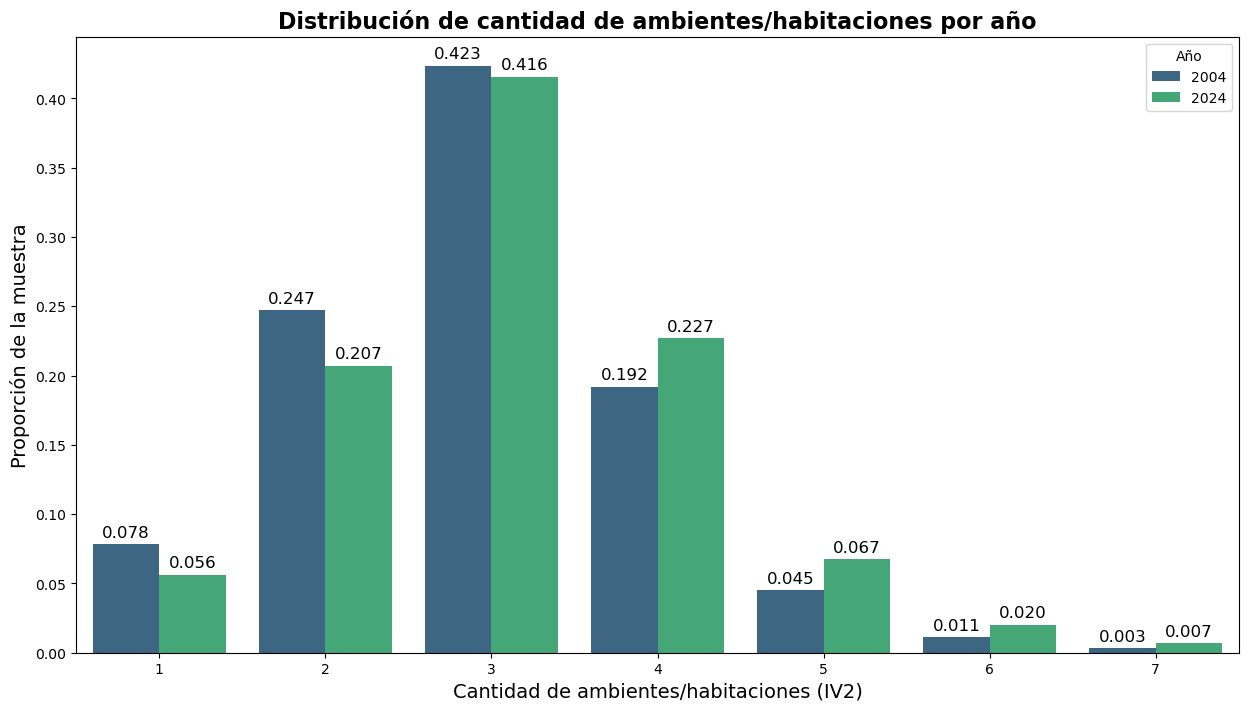

In [33]:
#Grafico de cantidad de ambientes IV2 para 2004 y 2024
#Definicion de variables
prop_04 = combined_04['IV2'].value_counts(normalize=True).reset_index()
prop_04.columns = ['IV2', 'Proporcion']
prop_04['Year'] = '2004'

prop_24 = combined_24['IV2'].value_counts(normalize=True).reset_index()
prop_24.columns = ['IV2', 'Proporcion']
prop_24['Year'] = '2024'

prop_combined = pd.concat([prop_04, prop_24])

# Grafico
plt.figure(figsize=(15, 8))
ax = sns.barplot(x='IV2', y='Proporcion', hue='Year', data=prop_combined, palette='viridis')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=12, padding=3)
    
plt.title('Distribución de cantidad de ambientes/habitaciones por año', fontsize=16, fontweight= 'bold')
plt.xlabel('Cantidad de ambientes/habitaciones (IV2)', fontsize=14)
plt.ylabel('Proporción de la muestra', fontsize=14)
plt.legend(title='Año')
plt.xticks()
plt.show()

In [34]:
# II7: Regimen de tenencia - 2004
tenencia04 = combined_04_total['II7'].value_counts().reset_index()
tenencia04.columns = ['II7', 'Frecuencia']
total_muestra = len(combined_04_total)
tenencia04['Proporción'] = round(tenencia04['Frecuencia'] / total_muestra, 4)

tenencia04

,II7,Frecuencia,Proporción
0,Propietario de la vivienda y el terreno,3391,0.6535
1,Inquilino/arrendatario de la vivienda,666,0.1283
2,Propietario de la vivienda solamente,334,0.0644
3,Ocupante gratuito (con permiso),316,0.0609
4,Ocupante por pago de impuestos/expensas,277,0.0534
5,Ocupante en relación de dependencia,99,0.0191
6,Está en sucesión,63,0.0121
7,Ocupante de hecho (sin permiso),20,0.0039
8,Otra situación,15,0.0029
9,0.0,8,0.0015


In [35]:
# II7: Regimen de tenencia - 2024
tenencia24 = combined_24_total['II7'].value_counts().reset_index()
tenencia24.columns = ['II7', 'Frecuencia']
total_muestra = len(combined_24_total)
tenencia24['Proporción'] = round(tenencia24['Frecuencia'] / total_muestra, 4)

tenencia24

,II7,Frecuencia,Proporción
0,1,2600,0.6195
1,3,794,0.1892
2,2,325,0.0774
3,6,301,0.0717
4,4,101,0.0241
5,8,49,0.0117
6,7,12,0.0029
7,5,7,0.0017
8,9,7,0.0017
9,0,1,0.0002


In [36]:
# IV1: Tipo de vivienda - 2004
tipovivienda04 = combined_04_total['IV1'].value_counts().reset_index()
tipovivienda04.columns = ['IV1', 'Frecuencia']
total_muestra = len(combined_04_total)
tipovivienda04['Proporción'] = round(tipovivienda04['Frecuencia'] / total_muestra, 4)

tipovivienda04

,IV1,Frecuencia,Proporción
0,Casa,3618,0.6972
1,Departamento,1505,0.2900
2,Pieza de inquilinato,30,0.0058
3,Otro,22,0.0042
4,Pieza en hotel/pensión,14,0.0027


In [37]:
# IV1: Tipo de vivienda - 2024
tipovivienda24 = combined_24_total['IV1'].value_counts().reset_index()
tipovivienda24.columns = ['IV1', 'Frecuencia']
total_muestra = len(combined_24_total)
tipovivienda24['Proporción'] = round(tipovivienda24['Frecuencia'] / total_muestra, 4)

tipovivienda24

,IV1,Frecuencia,Proporción
0,1,3096,0.7377
1,2,1070,0.2549
2,4,19,0.0045
3,6,8,0.0019
4,3,2,0.0005
5,5,2,0.0005


## 5. Clasificacion y regularizacion

#### (1) Armado de base, separación train-test, estandarización

In [38]:
#Filtramos las observaciones que no contestaron a la ocupacion
datos_04 = combined_04[combined_04['ESTADO'] != 0]
datos_24 = combined_24 [combined_24 ['ESTADO'] !=0]

#Eliminamos ciertas variables que no sirven para la prediccion
sacar_pre_lasso = ['CODUSU', 'ANO4', 'TRIMESTRE', 'ESTADO', 'AGLOMERADO', 'COMPONENTE', 'REGION', 'REALIZADA']
datos_04 = datos_04.drop (columns = sacar_pre_lasso)
datos_24 = datos_24.drop (columns = sacar_pre_lasso)

In [39]:
# Separacion de x e y
X_2004 = datos_04.drop(columns=['desocupado'])
y_2004 = datos_04['desocupado']
X_2024 = datos_24.drop(columns=['desocupado'])
y_2024 = datos_24['desocupado']

In [40]:
# Separacion de la base train test para cada ano. 
#Semilla 101

x_train24, x_test24, y_train_24, y_test_24 = train_test_split(X_2024, y_2024, test_size=0.3, random_state=101)
x_train04, x_test04, y_train_04, y_test_04 = train_test_split(X_2004, y_2004, test_size=0.3, random_state=101)


In [41]:
#Estandarizacion de columnas
columnas_a_estandarizar_04 = x_train04.select_dtypes(include=['int64', 'float64']).columns
columnas_a_estandarizar_24 = x_train24.select_dtypes(include=['int64', 'float64']).columns

sc_04 = StandardScaler()
sc_24 = StandardScaler()

x_train_04_transformed = x_train04.copy()
x_train_04_transformed[columnas_a_estandarizar_04] = sc_04.fit_transform(x_train04[columnas_a_estandarizar_04])

x_train_24_transformed = x_train24.copy()
x_train_24_transformed[columnas_a_estandarizar_24] = sc_24.fit_transform(x_train24[columnas_a_estandarizar_24])

x_test_04_transformed = x_test04.copy()
x_test_04_transformed[columnas_a_estandarizar_04] = sc_04.transform(x_test04[columnas_a_estandarizar_04])

x_test_24_transformed = x_test24.copy()
x_test_24_transformed[columnas_a_estandarizar_24] = sc_24.transform(x_test24[columnas_a_estandarizar_24])

x_train_04 = x_train_04_transformed
x_test_04 = x_test_04_transformed
x_train_24 = x_train_24_transformed
x_test_24 = x_test_24_transformed


#### (4) LASSO penalidad = 1

In [42]:
#Regresion logistica con penalidad LASSO
#### 2004
alpha = 1
log04_lasso = LogisticRegression(penalty='l1', C=(1/alpha), solver='liblinear').fit(x_train_04, y_train_04)
y_test_pred_score_04_lasso = log04_lasso.predict_proba(x_train_04)[:,1]
y_pred_log04_lasso = log04_lasso.predict(x_test_04)

#### 2024
log24_lasso = LogisticRegression(penalty='l1', C=(1/alpha), solver='liblinear').fit(x_train_24, y_train_24)
y_test_pred_score_24_lasso = log24_lasso.predict_proba(x_train_24)[:,1]
y_pred_log24_lasso = log24_lasso.predict(x_test_24)

Matriz de confusion (Reg Log LASSO 2004)
 [[1413   16]
 [ 109   19]]

AUC Reg Log (2004): 0.5686


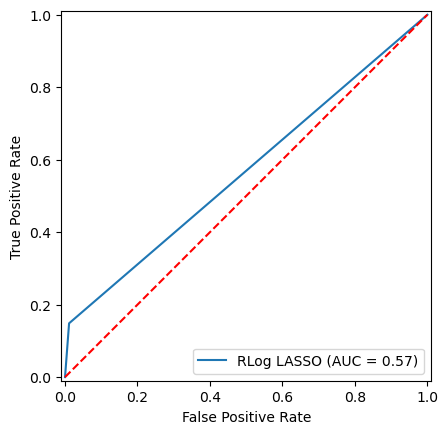

La accuracy del modelo (Reg Log LASSO 2004) es: 0.9197


In [43]:
#### Medidas de precision Regresion logistica LASSO para 2004
#Matriz de confusion
conflog04_lasso = confusion_matrix(y_test_04, y_pred_log04_lasso) 
print("Matriz de confusion (Reg Log LASSO 2004)\n", conflog04_lasso)

#AUC
auc_log04_lasso = roc_auc_score(y_test_04, y_pred_log04_lasso)
print('\nAUC Reg Log (2004): %.4f' %auc_log04_lasso)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_log04_lasso)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log04_lasso, estimator_name='RLog LASSO')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log04_lasso = accuracy_score(y_test_04, y_pred_log04_lasso)
print("La accuracy del modelo (Reg Log LASSO 2004) es: %.4f" %accuracy_log04_lasso)

Matriz de confusion (Reg Log LASSO 2024)
 [[1182    0]
 [  51   15]]

AUC Reg Log LASSO (2024): 0.6136


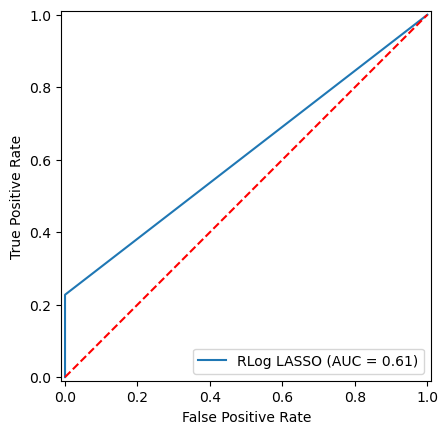

La accuracy del modelo (Reg Log LASSO 2024) es: 0.9591


In [44]:
#### Medidas de precision Regresion logistica LASSO para 2024
#Matriz de confusion
conflog24_lasso = confusion_matrix(y_test_24, y_pred_log24_lasso) 
print("Matriz de confusion (Reg Log LASSO 2024)\n", conflog24_lasso)

#AUC
auc_log24_lasso = roc_auc_score(y_test_24, y_pred_log24_lasso)
print('\nAUC Reg Log LASSO (2024): %.4f' %auc_log24_lasso)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_log24_lasso)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log24_lasso, estimator_name='RLog LASSO')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

# #MSE
# ecm_a1_l24 = mean_squared_error(y_test_24, y_pred_log24_lasso)
# print("Error cuadrático medio:", ecm_a1_l24) 

#Accuracy
accuracy_log24_lasso = accuracy_score(y_test_24, y_pred_log24_lasso)
print("La accuracy del modelo (Reg Log LASSO 2024) es: %.4f" %accuracy_log24_lasso)

#### (4) Ridge penalidad = 1

In [45]:
#Regresion logistica con penalidad ridge 
#### 2004
alpha = 1
log04_ridge = LogisticRegression(penalty='l2', C=(1/alpha), solver='liblinear').fit(x_train_04, y_train_04)
y_test_pred_score_04_ridge = log04_ridge.predict_proba(x_train_04)[:,1]
y_pred_log04_ridge = log04_ridge.predict(x_test_04)

#### 2024
log24_ridge = LogisticRegression(penalty='l2', C=(1/alpha), solver='liblinear').fit(x_train_24, y_train_24)
y_test_pred_score_24_ridge = log24_ridge.predict_proba(x_train_24)[:,1]
y_pred_log24_ridge = log24_ridge.predict(x_test_24)

Matriz de confusion (Reg Log ridge 2004)
 [[1407   22]
 [ 108   20]]

AUC Reg Log ridge (2004): 0.5704


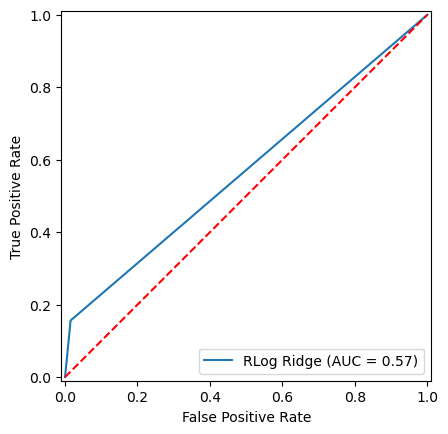

La accuracy del modelo (Reg Log ridge 2004) es: 0.9165


In [46]:
#### Medidas de precision Regresion logistica Ridge para 2004
#Matriz de confusion
conflog04_ridge = confusion_matrix(y_test_04, y_pred_log04_ridge) 
print("Matriz de confusion (Reg Log ridge 2004)\n", conflog04_ridge)

#AUC
auc_log04_ridge = roc_auc_score(y_test_04, y_pred_log04_ridge)
print('\nAUC Reg Log ridge (2004): %.4f' %auc_log04_ridge)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_log04_ridge)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log04_ridge, estimator_name='RLog Ridge')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log04_ridge = accuracy_score(y_test_04, y_pred_log04_ridge)
print("La accuracy del modelo (Reg Log ridge 2004) es: %.4f" %accuracy_log04_ridge)

Matriz de confusion (Reg Log ridge 2024)
 [[1181    1]
 [  56   10]]

AUC Reg Log ridge (2024): 0.5753


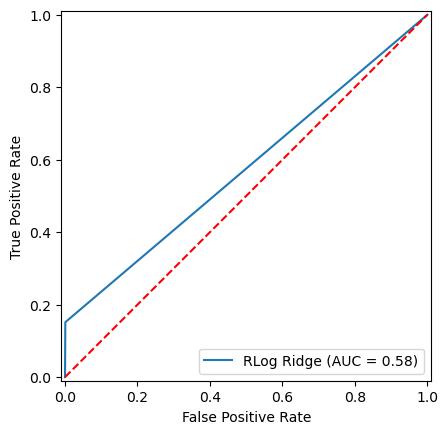

La accuracy del modelo (Reg Log ridge 2024) es: 0.9543


In [47]:
#### Medidas de precision Regresion logistica ridge para 2024
#Matriz de confusion
conflog24_ridge = confusion_matrix(y_test_24, y_pred_log24_ridge) 
print("Matriz de confusion (Reg Log ridge 2024)\n", conflog24_ridge)

#AUC
auc_log24_ridge = roc_auc_score(y_test_24, y_pred_log24_ridge)
print('\nAUC Reg Log ridge (2024): %.4f' %auc_log24_ridge)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_log24_ridge)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log24_ridge, estimator_name='RLog Ridge')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log24_ridge = accuracy_score(y_test_24, y_pred_log24_ridge)
print("La accuracy del modelo (Reg Log ridge 2024) es: %.4f" %accuracy_log24_ridge)

#### (5) Selección de alpha con CV

##### Modelos óptimos - LASSO

In [48]:
#LASSO 2004
# Definimos los lambdas (alphas) para 10-fold CV 
alphas = 10 ** np.array([*range(-5, 6)], dtype=float) 
Cs = 1 / alphas

#Modelo de reg log con LASSO con 10-fold CV
log_lasso_cv_04 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l1', solver='saga', scoring='roc_auc', refit=True, max_iter=1000, n_jobs=-1)
log_lasso_cv_04.fit(x_train_04, y_train_04)

print("Mejor valor de C:", log_lasso_cv_04.C_[0])
print("El mejor valor de alpha:", (1/log_lasso_cv_04.C_[0]))

c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejor valor de C: 0.1
El mejor valor de alpha: 10.0


c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [49]:
#Resultados Modelo LASSO optimo - 2004
print("Mejor valor de C:", log_lasso_cv_04.C_[0])
print("El mejor valor de alpha:", (1 / log_lasso_cv_04.C_[0]))
print("Dimensiones de x_train_04:", x_train_04.shape)
print("Dimensiones de coeficientes del modelo:", log_lasso_cv_04.coef_.shape)

# Comprobar que el número de coeficientes coincida con las columnas de x_train_04
coeficientes = log_lasso_cv_04.coef_[0]

variables_descartadas_04 = [x_train_04.columns[i] for i in range(len(coeficientes)) if coeficientes[i] == 0]
variables_no_descartadas_04 = [x_train_04.columns[i] for i in range(len(coeficientes)) if coeficientes[i] != 0]

print("Variables descartadas por LASSO:", variables_descartadas_04)
print("Variables seleccionadas por LASSO:", variables_no_descartadas_04)

cantidad_descartadas_04 = len(variables_descartadas_04)
cantidad_no_descartadas_04 = len(variables_no_descartadas_04)

print("Cantidad de variables descartadas:", cantidad_descartadas_04)
print("Cantidad de variables no descartadas:", cantidad_no_descartadas_04)

Mejor valor de C: 0.1
El mejor valor de alpha: 10.0
Dimensiones de x_train_04: (3632, 274)
Dimensiones de coeficientes del modelo: (1, 274)
Variables descartadas por LASSO: ['P47T', 'RDECINDR', 'GDECINDR', 'ADECINDR', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI', 'II1', 'II2', 'II5_1', 'ITF', 'DECIFR', 'RDECIFR', 'GDECIFR', 'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR', 'IV11_A cámara séptica y pozo ciego', 'IV11_Sólo a pozo ciego', 'IV11_A hoyo/excavación en la tierra', 'V10_No', 'V10_Ns./Nr.', 'V2_No', 'V2_Ns./Nr.', 'II7_Propietario de la vivienda y el terreno', 'II7_Propietario de la vivienda solamente', 'II7_Inquilino/arrendatario de la vivienda', 'II7_Ocupante por pago de impuestos/expensas', 'II7_Ocupante en relación de dependencia', 'II7_Ocupante gratuito (con permiso)', 'II7_Ocupante de hecho (sin permiso)', 'II7_Está en sucesión', 'II7_Otra situación', 'CH03_Hijo/Hijastro', 'CH03_Yerno/Nuera', 'CH03_Nieto', 'CH03_Madre/

Matriz de confusion (LASSO 2004 optimo)
 [[1427    2]
 [ 125    3]]

AUC LASSO optimo (2004): 0.5110


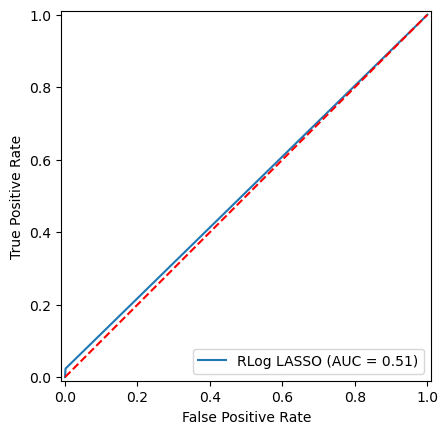

La accuracy del modelo (Reg Log ridge 2004) es: 0.9184


In [50]:
#Definicion del modelo optimo LASSO 2004
alpha_lopt04 = 1 / log_lasso_cv_04.C_[0]
log_lasso_04_opt = LogisticRegression(penalty='l1', C=(1/alpha_lopt04), solver='liblinear').fit(x_train_04, y_train_04)
y_test_pred_score_lopt04 = log_lasso_04_opt.predict_proba(x_train_04)[:,1]
y_pred_lopt04= log_lasso_04_opt.predict(x_test_04)

#### Medidas de precision - LASSO 2004 optimo
#Matriz de confusion
conflog_lopt04 = confusion_matrix(y_test_04, y_pred_lopt04) 
print("Matriz de confusion (LASSO 2004 optimo)\n", conflog_lopt04)

#AUC
auc_lopt04 = roc_auc_score(y_test_04, y_pred_lopt04)
print('\nAUC LASSO optimo (2004): %.4f' %auc_lopt04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_lopt04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lopt04, estimator_name='RLog LASSO')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lopt04 = accuracy_score(y_test_04, y_pred_lopt04)
print("La accuracy del modelo (Reg Log ridge 2004) es: %.4f" %accuracy_lopt04)

In [51]:
#LASSO 2024
# Definimos los lambdas (alphas) para 10-fold CV 
alphas = 10 ** np.array([*range(-5, 6)], dtype=float)
Cs = 1 / alphas

log_lasso_cv_24 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l1', solver='saga', scoring='roc_auc', refit=True, max_iter=1000, n_jobs=-1)
log_lasso_cv_24.fit(x_train_24, y_train_24)

print("Mejor valor de C:", log_lasso_cv_24.C_[0])
print("El mejor valor de alpha:", (1/log_lasso_cv_24.C_[0]))

c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejor valor de C: 1.0
El mejor valor de alpha: 1.0


In [52]:
#Resultados Modelo LASSO optimo - 2004
print("Mejor valor de C:", log_lasso_cv_24.C_[0])
print("El mejor valor de alpha:", (1 / log_lasso_cv_24.C_[0]))
print("Dimensiones de x_train_24:", x_train_24.shape)
print("Dimensiones de coeficientes del modelo:", log_lasso_cv_24.coef_.shape)

# Comprobar que el número de coeficientes coincida con las columnas de x_train_04
coeficientes = log_lasso_cv_24.coef_[0]

variables_descartadas_24 = [x_train_24.columns[i] for i in range(len(coeficientes)) if coeficientes[i] == 0]
variables_no_descartadas_24 = [x_train_24.columns[i] for i in range(len(coeficientes)) if coeficientes[i] != 0]

print("Variables descartadas por LASSO:", variables_descartadas_24)
print("Variables seleccionadas por LASSO:", variables_no_descartadas_24)

cantidad_descartadas_24 = len(variables_descartadas_24)
cantidad_no_descartadas_24 = len(variables_no_descartadas_24)

print("Cantidad de variables descartadas:", cantidad_descartadas_24)
print("Cantidad de variables no descartadas:", cantidad_no_descartadas_24)

Mejor valor de C: 1.0
El mejor valor de alpha: 1.0
Dimensiones de x_train_24: (2910, 260)
Dimensiones de coeficientes del modelo: (1, 260)
Variables descartadas por LASSO: ['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI', 'II5_1', 'IX_TOT', 'DECIFR', 'RDECIFR', 'GDECIFR', 'DECCFR', 'GDECCFR', 'ADECCFR', 'IV11_3', 'IV11_4', 'V10_9', 'V2_2', 'V2_9', 'II7_2', 'II7_5', 'II7_7', 'II7_8', 'II7_9', 'CH03_5', 'CH03_6', 'CH03_7', 'CH03_8', 'CH03_10', 'V19_B_2', 'V19_B_9', 'V5_9', 'NIVEL_ED_2', 'NIVEL_ED_4', 'II5_2', 'CH12_1', 'CH12_2', 'CH12_3', 'CH12_5', 'CH12_7', 'CH12_8', 'CH12_9', 'CH12_99', 'IV6_2', 'VII2_4_5', 'VII2_4_6', 'H15_2', 'IV1_2', 'IV1_3', 'IV1_4', 'IV1_5', 'IV1_6', 'VII2_3_3', 'VII2_3_4', 'VII2_3_5', 'VII2_3_6', 'VII2_3_47', 'VII2_2_2', 'VII2_2_3', 'VII2_2_6', 'VII2_2_7', 'VII2_2_98', 'V1_9', 'CH16_1', 'CH16_2', 'CH16_3', 'CH16_4', 'CH16_5', 'CH16_6', 'CH16_9', 'II4_3_1', 'II4_3_2', 'CH11_1', 'CH11_2', 'CH11_9', 'IV12

Matriz de confusion (LASSO 2024 optimo)
 [[1182    0]
 [  51   15]]

AUC LASSO optimo (2024): 0.6136


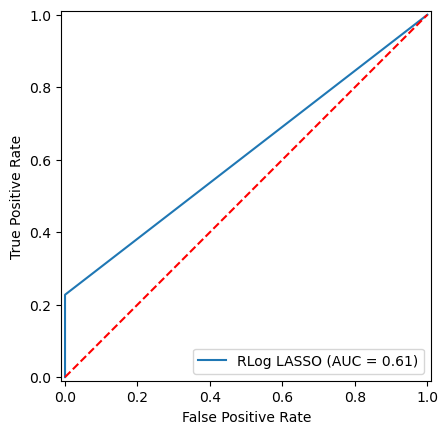

La accuracy del modelo (Reg Log ridge 2024) es: 0.9591


In [53]:
#Definicion del modelo optimo LASSO 2024
alpha_lopt24 = 1 / log_lasso_cv_24.C_[0]
log_lasso_24_opt = LogisticRegression(penalty='l1', C=(1/alpha_lopt24), solver='liblinear').fit(x_train_24, y_train_24)
y_test_pred_score_lopt24 = log_lasso_24_opt.predict_proba(x_train_24)[:,1]
y_pred_lopt24= log_lasso_24_opt.predict(x_test_24)

#### Medidas de precision - LASSO 2024 optimo
#Matriz de confusion
conflog_lopt24 = confusion_matrix(y_test_24, y_pred_lopt24) 
print("Matriz de confusion (LASSO 2024 optimo)\n", conflog_lopt24)

#AUC
auc_lopt24 = roc_auc_score(y_test_24, y_pred_lopt24)
print('\nAUC LASSO optimo (2024): %.4f' %auc_lopt24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_lopt24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lopt24, estimator_name='RLog LASSO')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lopt24 = accuracy_score(y_test_24, y_pred_lopt24)
print("La accuracy del modelo (Reg Log ridge 2024) es: %.4f" %accuracy_lopt24)

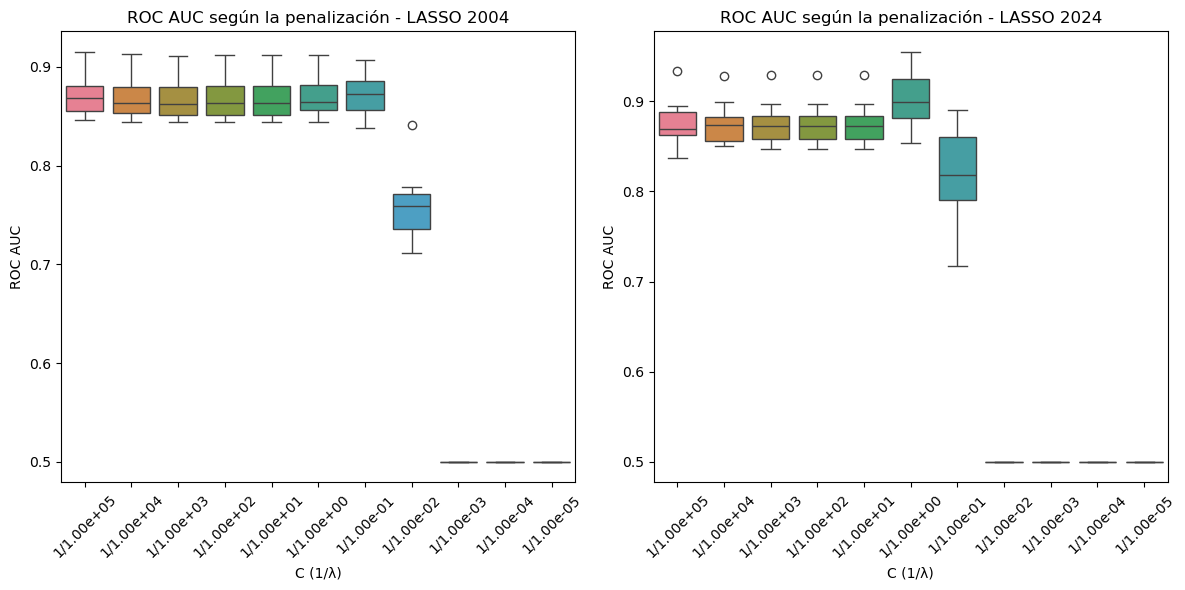

In [54]:
# Puntuaciones de ROC AUC para 2004 y 2024
roc_auc_lasso_04 = log_lasso_cv_04.scores_[1]  
roc_auc_lasso_24 = log_lasso_cv_24.scores_[1] 

# Los valores de C_ (inverso de alpha) para LogisticRegressionCV
C_04 = log_lasso_cv_04.Cs_ 
C_24 = log_lasso_cv_24.Cs_  

# BOX PLOTS: AUC segun valor de lambda
plt.figure(figsize=(12, 6))

# Box plot para Lasso 2004
plt.subplot(1, 2, 1)
sns.boxplot(data=roc_auc_lasso_04, orient='v')
plt.xticks(ticks=range(len(C_04)), labels=[f"1/{c:.2e}" for c in C_04], rotation=45)
plt.title("ROC AUC según la penalización - LASSO 2004")
plt.xlabel("C (1/λ)")
plt.ylabel("ROC AUC")

# Box plot para Lasso 2024
plt.subplot(1, 2, 2)
sns.boxplot(data=roc_auc_lasso_24, orient='v')
plt.xticks(ticks=range(len(C_24)), labels=[f"1/{c:.2e}" for c in C_24], rotation=45)
plt.title("ROC AUC según la penalización - LASSO 2024")
plt.xlabel("C (1/λ)")
plt.ylabel("ROC AUC")

plt.tight_layout()
plt.show()


##### Modelos óptimos - Ridge

In [55]:
#Ridge 2004
alphas= 10 ** np.array([*range(-5, 6)], dtype=float)
Cs = 1 / alphas
log_ridge_cv_04 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l2', solver='saga', scoring='roc_auc', refit=True, max_iter=1000, n_jobs=-1)
log_ridge_cv_04.fit(x_train_04, y_train_04)

print("Mejor valor de C:", log_ridge_cv_04.C_[0])
print("El mejor valor de alpha:", (1/log_ridge_cv_04.C_[0]))

c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejor valor de C: 0.1
El mejor valor de alpha: 10.0


Matriz de confusion (Ridge 2004 optimo)
 [[1422    7]
 [ 116   12]]

AUC Ridge optimo (2004): 0.5444


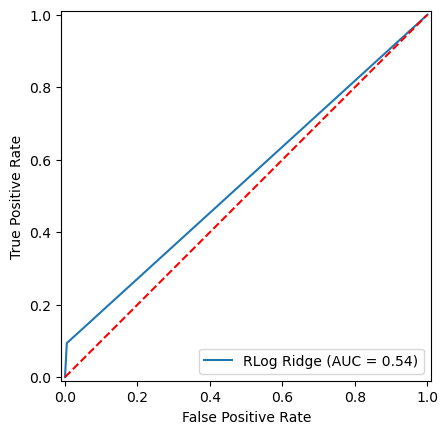

La accuracy del modelo (Reg Log Ridge 2004) es: 0.9210


In [56]:
#Definicion del modelo optimo Ridge 2004
alpha_ropt04 = 1 / log_ridge_cv_04.C_[0]
log_ridge_04_opt = LogisticRegression(penalty='l2', C=(1/alpha_ropt04), solver='liblinear').fit(x_train_04, y_train_04)
y_test_pred_score_ropt04 = log_ridge_04_opt.predict_proba(x_train_04)[:,1]
y_pred_ropt04= log_ridge_04_opt.predict(x_test_04)

#### Medidas de precision - LASSO 2004 optimo
#Matriz de confusion
conflog_ropt04 = confusion_matrix(y_test_04, y_pred_ropt04) 
print("Matriz de confusion (Ridge 2004 optimo)\n", conflog_ropt04)

#AUC
auc_ropt04 = roc_auc_score(y_test_04, y_pred_ropt04)
print('\nAUC Ridge optimo (2004): %.4f' %auc_ropt04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_ropt04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_ropt04, estimator_name='RLog Ridge')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_ropt04 = accuracy_score(y_test_04, y_pred_ropt04)
print("La accuracy del modelo (Reg Log Ridge 2004) es: %.4f" %accuracy_ropt04)

In [57]:
#Ridge 2024
alphas = 10 ** np.array([*range(-5, 6)], dtype=float)
Cs = 1 / alphas

log_ridge_cv_24 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l2', solver='saga', scoring='roc_auc', refit=True, max_iter=1000, n_jobs=-1)
log_ridge_cv_24.fit(x_train_24, y_train_24)

print("Mejor valor de C:", log_ridge_cv_24.C_[0])
print("El mejor valor de alpha:", (1/log_ridge_cv_24.C_[0]))

c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejor valor de C: 99999.99999999999
El mejor valor de alpha: 1e-05


c:\Users\magda\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Matriz de confusion (Ridge 2024 optimo)
 [[1168   14]
 [  45   21]]

AUC Ridge optimo (2024): 0.6532


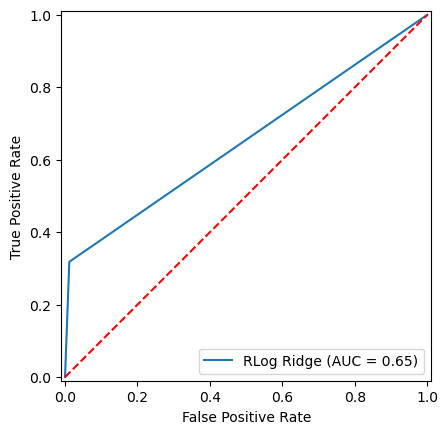

La accuracy del modelo (Reg Log Ridge 2024) es: 0.9527


In [58]:
#Definicion del modelo optimo Ridge 2024
alpha_ropt24 = 1 / log_ridge_cv_24.C_[0]
log_ridge_24_opt = LogisticRegression(penalty='l2', C=(1/alpha_ropt24), solver='liblinear').fit(x_train_24, y_train_24)
y_test_pred_score_ropt24 = log_ridge_24_opt.predict_proba(x_train_24)[:,1]
y_pred_ropt24= log_ridge_24_opt.predict(x_test_24)

#### Medidas de precision - LASSO 2004 optimo
#Matriz de confusion
conflog_ropt24 = confusion_matrix(y_test_24, y_pred_ropt24) 
print("Matriz de confusion (Ridge 2024 optimo)\n", conflog_ropt24)

#AUC
auc_ropt24 = roc_auc_score(y_test_24, y_pred_ropt24)
print('\nAUC Ridge optimo (2024): %.4f' %auc_ropt24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_ropt24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_ropt24, estimator_name='RLog Ridge')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_ropt24 = accuracy_score(y_test_24, y_pred_ropt24)
print("La accuracy del modelo (Reg Log Ridge 2024) es: %.4f" %accuracy_ropt24)

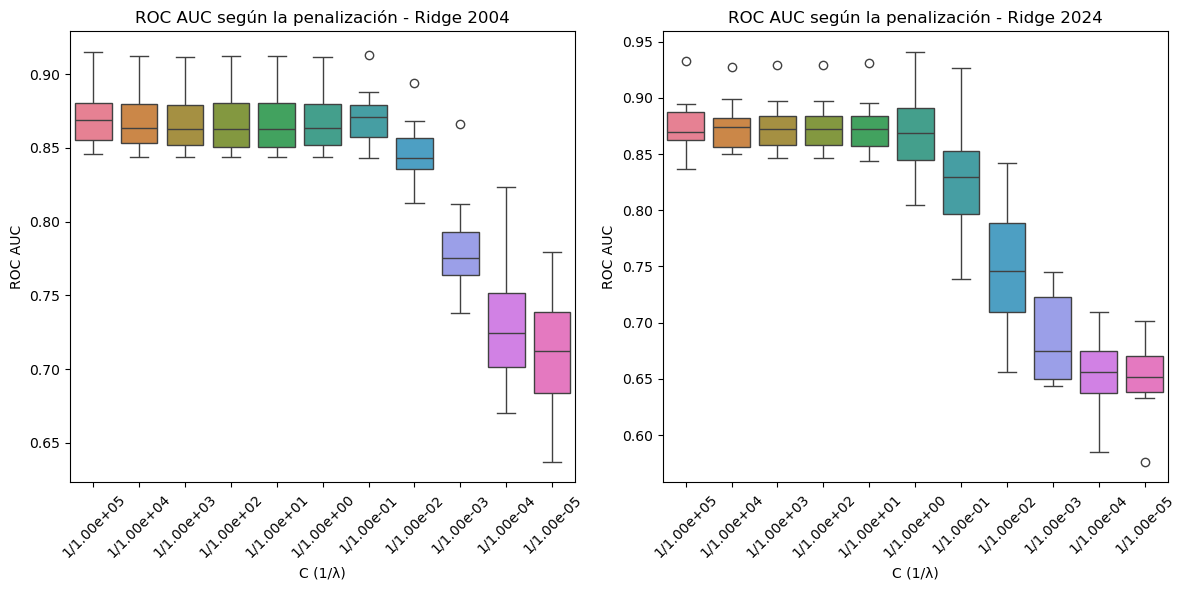

In [59]:
# Puntuaciones de ROC AUC para 2004 y 2024
roc_auc_ridge_04 = log_ridge_cv_04.scores_[1]  
roc_auc_ridge_24 = log_ridge_cv_24.scores_[1] 

# Los valores de C_ (inverso de alpha) para LogisticRegressionCV
C_04 = log_ridge_cv_04.Cs_  
C_24 = log_ridge_cv_24.Cs_  

# Box Plots para las puntuaciones ROC AUC segun penalizacion
plt.figure(figsize=(12, 6))

# Box plot para Lasso 2004
plt.subplot(1, 2, 1)
sns.boxplot(data=roc_auc_ridge_04, orient='v')
plt.xticks(ticks=range(len(C_04)), labels=[f"1/{c:.2e}" for c in C_04], rotation=45)
plt.title("ROC AUC según la penalización - Ridge 2004")
plt.xlabel("C (1/λ)")
plt.ylabel("ROC AUC")

# Box plot para Lasso 2024
plt.subplot(1, 2, 2)
sns.boxplot(data=roc_auc_ridge_24, orient='v')
plt.xticks(ticks=range(len(C_24)), labels=[f"1/{c:.2e}" for c in C_24], rotation=45)
plt.title("ROC AUC según la penalización - Ridge 2024")
plt.xlabel("C (1/λ)")
plt.ylabel("ROC AUC")

plt.tight_layout()
plt.show()


#### (5) Gráficos de LASSO

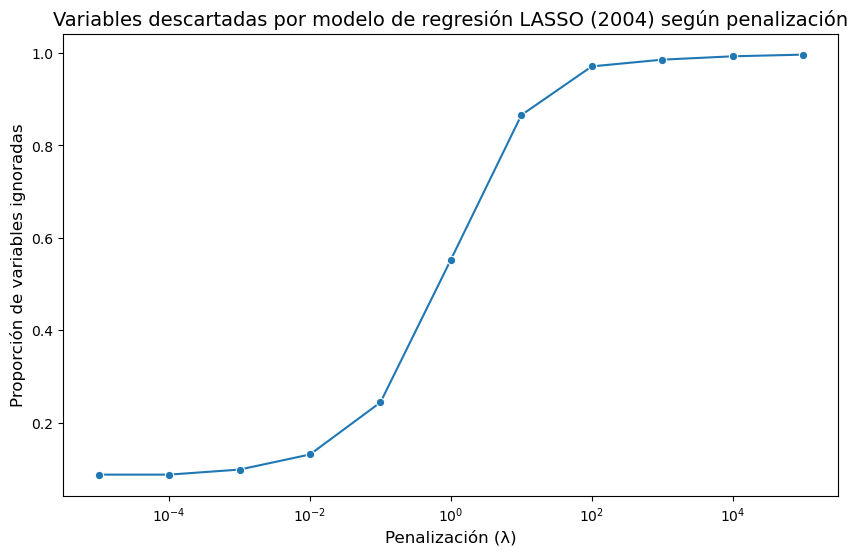

In [65]:
#Lineplot para proporcion de variables eliminadas por LASSO - 2004

lambda_values_04 =  10 ** np.array([*range(-5, 6)], dtype=float)  
proporciones_ignoradas_04 = []  

for lambda_val in lambda_values_04:
    alpha = lambda_val
    log04_lasso = LogisticRegression(penalty='l1', C=(1/alpha), solver='liblinear').fit(x_train_04, y_train_04)
    coef_zeros = np.sum(log04_lasso.coef_ == 0)
    proporcion_ignoradas = coef_zeros / len(datos_04.columns)
    proporciones_ignoradas_04.append(proporcion_ignoradas)

df_ignoradas = pd.DataFrame({
    'Lambda': lambda_values_04,
    'Proporcion_Ignoradas': proporciones_ignoradas_04
})

#Grafico de lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Lambda', y='Proporcion_Ignoradas', data=df_ignoradas, marker='o')

plt.title('Variables descartadas por modelo de regresión LASSO (2004) según penalización', fontsize=14)
plt.xlabel('Penalización (λ)', fontsize=12)
plt.ylabel('Proporción de variables ignoradas', fontsize=12)
plt.xscale('log')
plt.show()

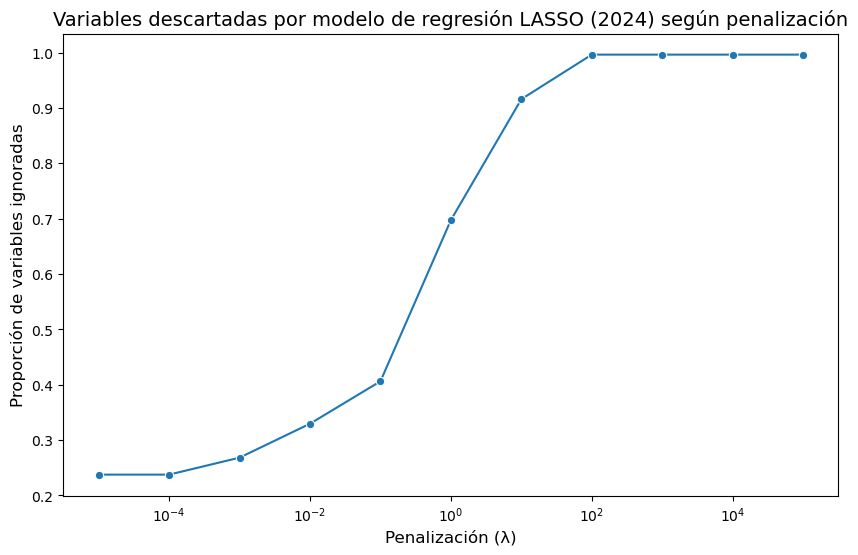

In [66]:
#Lineplot para proporcion de variables eliminadas por LASSO - 2004
lambda_values_24 =  10 ** np.array([*range(-5, 6)], dtype=float)  
proporciones_ignoradas_24 = []  

for lambda_val_24 in lambda_values_24:
    alpha = lambda_val_24
    log24_lasso = LogisticRegression(penalty='l1', C=(1/alpha), solver='liblinear').fit(x_train_24, y_train_24)
    coef_zeros = np.sum(log24_lasso.coef_ == 0)
    proporcion_ignoradas = coef_zeros / len(datos_24.columns)
    proporciones_ignoradas_24.append(proporcion_ignoradas)

df_ignoradas_24 = pd.DataFrame({
    'Lambda': lambda_values_24,
    'Proporcion_Ignoradas': proporciones_ignoradas_24
})

# Gráfico de lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Lambda', y='Proporcion_Ignoradas', data=df_ignoradas_24, marker='o')

plt.title('Variables descartadas por modelo de regresión LASSO (2024) según penalización', fontsize=14)
plt.xlabel('Penalización (λ)', fontsize=12)
plt.ylabel('Proporción de variables ignoradas', fontsize=12)
plt.xscale('log')
plt.show()